<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/APC_Exercises/set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The main topic of this problem set is **linear regression** and its variants.

# 1. Rocket motion

Our model tries to describe $s(t)$, where $s$ is the rocket height. Of course, we propose a physics-based model:

$$
y(t) = a + bt + ct^2
$$

At first, this problem seems non-linear. But if we work in the 2D feature space $\{z_1, z_2\}$ where $z_1 = t$ and $z_2 = t^2$, it becomes linear.

Therefore, we shall proceed with a linear regression model. 

We actually work in a 3D feature space, since we shall perform a pre-processing step of appending a constant unit-valued feature to each observation. This trick allow us to incorporate the bias term neatly to our closed-form solution for linear regression.

In [2]:
def gen_dataset():
    dt = 5
    t = np.arange(5, 30+dt, dt)
    s = np.array([722, 1073, 1178, 1177, 781, 102])
    N = t.size
    data = np.array([np.ones(N), t, t**2]).T.reshape(N, 3) # N, D
    labels = s.T
    return data, labels

In [3]:
X, y = gen_dataset()
print(X.shape, y.shape)

(6, 3) (6,)


In [4]:
# Visualize dataset
X_df = pd.DataFrame(X, columns=["bias", "t", "t^2"])
X_df

,bias,t,t^2
0,1.0,5.0,25.0
1,1.0,10.0,100.0
2,1.0,15.0,225.0
3,1.0,20.0,400.0
4,1.0,25.0,625.0
5,1.0,30.0,900.0


In [19]:
def linreg(X, y, lamb=0, return_weights=False):
    XTX = (X.T).dot(X)
    to_invert = (XTX + lamb*np.eye(XTX.shape[0]))
    XTy = (X.T).dot(y)
    w = np.linalg.inv(to_invert).dot(XTy)
    preds = X.dot(w)
    if return_weights:
        return preds, w
    else:
        return preds

In [21]:
# Without regularization
preds, w = linreg(X, y, lamb=0, return_weights=True)

In [22]:
print(w, w.shape)

[ 44.2        156.12428571  -5.11      ] (3,)


Text(0.5, 0, 't')

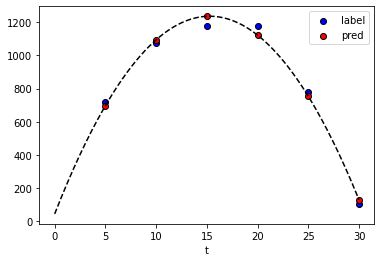

In [24]:
plt.scatter(X[:, 1], y, color="blue",
            marker="o", ec="k", label="label")
plt.scatter(X[:, 1], preds, color="red",
            marker="o", ec="k", label="pred")
t = np.linspace(0, X[:, 1].max(), 200)
plt.plot(t, w[0] + w[1]*t + w[2]*(t**2),
         color="k", ls="--")
plt.legend()
plt.xlabel("t")

In [25]:
# With regularization, lambda=0.5
preds_reg, w_reg = linreg(X, y, lamb=0.5, return_weights=True)

In [26]:
print(w_reg, w_reg.shape)

[ 28.81692798 157.42734984  -5.13590407] (3,)


Text(0.5, 0, 't')

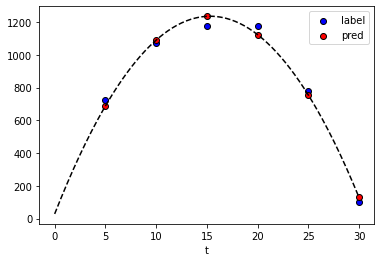

In [27]:
plt.scatter(X[:, 1], y, color="blue",
            marker="o", ec="k", label="label")
plt.scatter(X[:, 1], preds_reg, color="red",
            marker="o", ec="k", label="pred")
t = np.linspace(0, X[:, 1].max(), 200)
plt.plot(t, w_reg[0] + w_reg[1]*t + w_reg[2]*(t**2),
         color="k", ls="--")
plt.legend()
plt.xlabel("t")

In [31]:
w_df = pd.DataFrame(np.array([w, w_reg]).T, columns=["default", "regularized"])
w_df

,default,regularized
0,44.200000,28.816928
1,156.124286,157.427350
2,-5.110000,-5.135904
